In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, # ★BCEと同じモデルをロード
    BertPreTrainedModel, # ★カスタムモデルのラッパーとして使用
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# CUDAのデバッグ用
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA GeForce RTX 3080 Ti


In [2]:
# --- 2. 設定 ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/longformer-base-4096"

# --- 実験計画からのパラメータ ---
MAX_LENGTH = 2048
LEARNING_RATE = 2e-5
MARGIN_RANKING_MARGIN = 1.0 # ▼▼▼ マージンを1.0に設定 ▼▼▼

# --- ドライラン用の設定 ---
OUTPUT_MODEL_DIR = "models/cencoder_margin_DRYRUN"
# (Longformer + 2回実行のため、バッチサイズは最小限に)
DRY_RUN_BATCH_SIZE = 2 # メモリ不足の場合は 1
EPOCHS = 1
DRY_RUN_SUBSET_FRAC = 0.01 # データの1%だけを使用
GRAD_ACCUM_STEPS = 1

print("Configuration set for C-Encoder (Margin) DRY RUN.")

Configuration set for C-Encoder (Margin) DRY RUN.


In [3]:
# --- 3. カスタムモデルクラスの定義 ---

class CrossEncoderMarginModel(BertPreTrainedModel):
    """
    C-Encoder (Margin) モデル
    内部で C-Encoder (BCE) と同じモデルを2回呼び出す
    """
    def __init__(self, config):
        super(CrossEncoderMarginModel, self).__init__(config)
        # 1. Longformerベースのスコア計算機 (num_labels=1)
        #    これが重みを共有する本体
        self.scorer = AutoModelForSequenceClassification.from_config(config)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_neg=None,
        attention_mask_neg=None,
        labels=None, # MarginRankingLossでは 'labels' は使わない
        **kwargs
    ):
        # 1. ポジティブペアのスコアを計算
        #    入力: (Anchor, Positive)
        output_pos = self.scorer(input_ids=input_ids, attention_mask=attention_mask)
        score_positive = output_pos.logits

        # 2. ネガティブペアのスコアを計算
        #    入力: (Anchor, Negative)
        output_neg = self.scorer(input_ids=input_ids_neg, attention_mask=attention_mask_neg)
        score_negative = output_neg.logits

        # 損失はTrainer側で計算
        return SequenceClassifierOutput(
            loss=None,
            # 2つのスコアをlogitsとして渡す
            logits=(score_positive, score_negative),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'CrossEncoderMarginModel' defined.")

Custom model class 'CrossEncoderMarginModel' defined.


In [4]:
# --- 4. データセットの読み込みとTripletへの変換 ---
print(f"Loading dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# ▼▼▼ ドライラン用に1%のサブセットをサンプリング ▼▼▼
df = df_full.sample(frac=DRY_RUN_SUBSET_FRAC, random_state=42)
print(f"Using {len(df)} pairs for dry run ({DRY_RUN_SUBSET_FRAC*100}%)")

pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

if pos_df.empty or neg_df.empty:
    raise ValueError("Dry run subset does not contain both positive and negative samples.")

# --- Tripletの作成 (Anchor, Positive, Negative) ---
triplets = []
negative_abstracts = neg_df['abstract_b'].tolist()
if not negative_abstracts:
    negative_abstracts = pos_df['abstract_b'].tolist()

for index, row in pos_df.iterrows():
    anchor = row['abstract_a']
    positive = row['abstract_b']
    negative = np.random.choice(negative_abstracts)
    
    triplets.append({
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    })

df_triplets = pd.DataFrame(triplets)
df_triplets['labels'] = 0 # ダミーのlabels列
print(f"Created {len(df_triplets)} triplets for the dry run.")

raw_dataset = Dataset.from_pandas(df_triplets)
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Triplet dataset loaded: {dataset}")

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Using 346 pairs for dry run (1.0%)
Created 67 triplets for the dry run.
Triplet dataset loaded: DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 53
    })
    validation: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 14
    })
})


In [5]:
# --- 5. トークナイズ処理 ---
print("Initializing Longformer tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_cencoder_margin_function(examples):
    # (Anchor, Positive) ペアをトークン化
    tokenized_pos = tokenizer(
        examples["anchor"], examples["positive"], 
        padding="max_length", truncation=True, max_length=MAX_LENGTH
    )
    # (Anchor, Negative) ペアをトークン化
    tokenized_neg = tokenizer(
        examples["anchor"], examples["negative"], 
        padding="max_length", truncation=True, max_length=MAX_LENGTH
    )
    
    # 'input_ids' は (A,P) ペア
    # 'input_ids_neg' は (A,N) ペア
    return {
        "input_ids": tokenized_pos["input_ids"],
        "attention_mask": tokenized_pos["attention_mask"],
        "input_ids_neg": tokenized_neg["input_ids"],
        "attention_mask_neg": tokenized_neg["attention_mask"],
    }

print("Tokenizing C-Encoder Margin dataset...")
tokenized_datasets = dataset.map(tokenize_cencoder_margin_function, batched=True, num_proc=2,
                                 remove_columns=["anchor", "positive", "negative"])
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Initializing Longformer tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing C-Encoder Margin dataset...


Map (num_proc=2):   0%|          | 0/53 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

Tokenization complete.


In [6]:
# --- 6. カスタムTrainerの定義 ---

class MarginRankingTrainer(Trainer):
    """
    MarginRankingLossを計算するためにTrainerを継承
    """
    def __init__(self, *args, margin=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        self.loss_fct = nn.MarginRankingLoss(margin=self.margin)
        print(f"MarginRankingTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        if "labels" in inputs:
            inputs.pop("labels")
            
        # (score_positive, score_negative) がlogitsとして返ってくる
        outputs = model(**inputs)
        score_positive, score_negative = outputs.logits
        
        # MarginRankingLossの計算
        # ターゲット 'y' は 1 を設定
        # (loss(x1, x2, y) = max(0, -y * (x1 - x2) + margin))
        # (y=1 の場合、max(0, -(score_pos - score_neg) + margin))
        # (score_pos > score_neg + margin となるように学習)
        target = torch.ones_like(score_positive)
        
        loss = self.loss_fct(score_positive, score_negative, target)

        return (loss, outputs) if return_outputs else loss

print("Custom 'MarginRankingTrainer' defined.")

Custom 'MarginRankingTrainer' defined.


In [7]:
# --- 7. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
# ★num_labels=1★ でロード (スコア計算機として)
# CrossEncoderMarginModel が内部でこれを使用
model = CrossEncoderMarginModel.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=1 
).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数 (RankNet Accuracy と同じ)
def compute_metrics_margin(eval_pred):
    score_pos, score_neg = eval_pred.predictions
    # 成功 = score_positive > score_negative
    preds = (score_pos.squeeze() > score_neg.squeeze())
    accuracy = preds.mean().item()
    return {'rank_accuracy': accuracy}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=DRY_RUN_BATCH_SIZE,
    per_device_eval_batch_size=DRY_RUN_BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_steps=1,
    warmup_ratio=0.1,
    gradient_checkpointing=True, # メモリ節約
)
print("Training arguments set for DRY RUN.")

Loading custom model: allenai/longformer-base-4096


You are using a model of type longformer to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of CrossEncoderMarginModel were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['scorer.bert.embeddings.LayerNorm.bias', 'scorer.bert.embeddings.LayerNorm.weight', 'scorer.bert.embeddings.position_embeddings.weight', 'scorer.bert.embeddings.token_type_embeddings.weight', 'scorer.bert.embeddings.word_embeddings.weight', 'scorer.bert.encoder.layer.0.attention.output.LayerNorm.bias', 'scorer.bert.encoder.layer.0.attention.output.LayerNorm.weight', 'scorer.bert.encoder.layer.0.attention.output.dense.bias', 'scorer.bert.encoder.layer.0.attention.output.dense.weight', 'scorer.bert.encoder.layer.0.attention.self.key.bias', 'scorer.bert.encoder.layer.0.attention.self.key.weight', 'scorer.bert.encoder.layer.0.attention.self.query.bias', 'scorer.bert.encoder.layer.0.attention.s

Custom model loaded.
Training arguments set for DRY RUN.


In [8]:
# --- 8. 訓練の開始 ---
trainer = MarginRankingTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_margin, # ★専用メトリクスに変更
    margin=MARGIN_RANKING_MARGIN
)

print("\n--- Starting Model Training (C-Encoder Margin DRY RUN) ---")
trainer.train()
print("--- Model Training Complete ---")

MarginRankingTrainer initialized with margin=1.0

--- Starting Model Training (C-Encoder Margin DRY RUN) ---


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Rank Accuracy
10,0.925700,1.000299,0.428571
20,0.707200,1.000180,0.500000


--- Model Training Complete ---



--- Visualizing Training Results ---


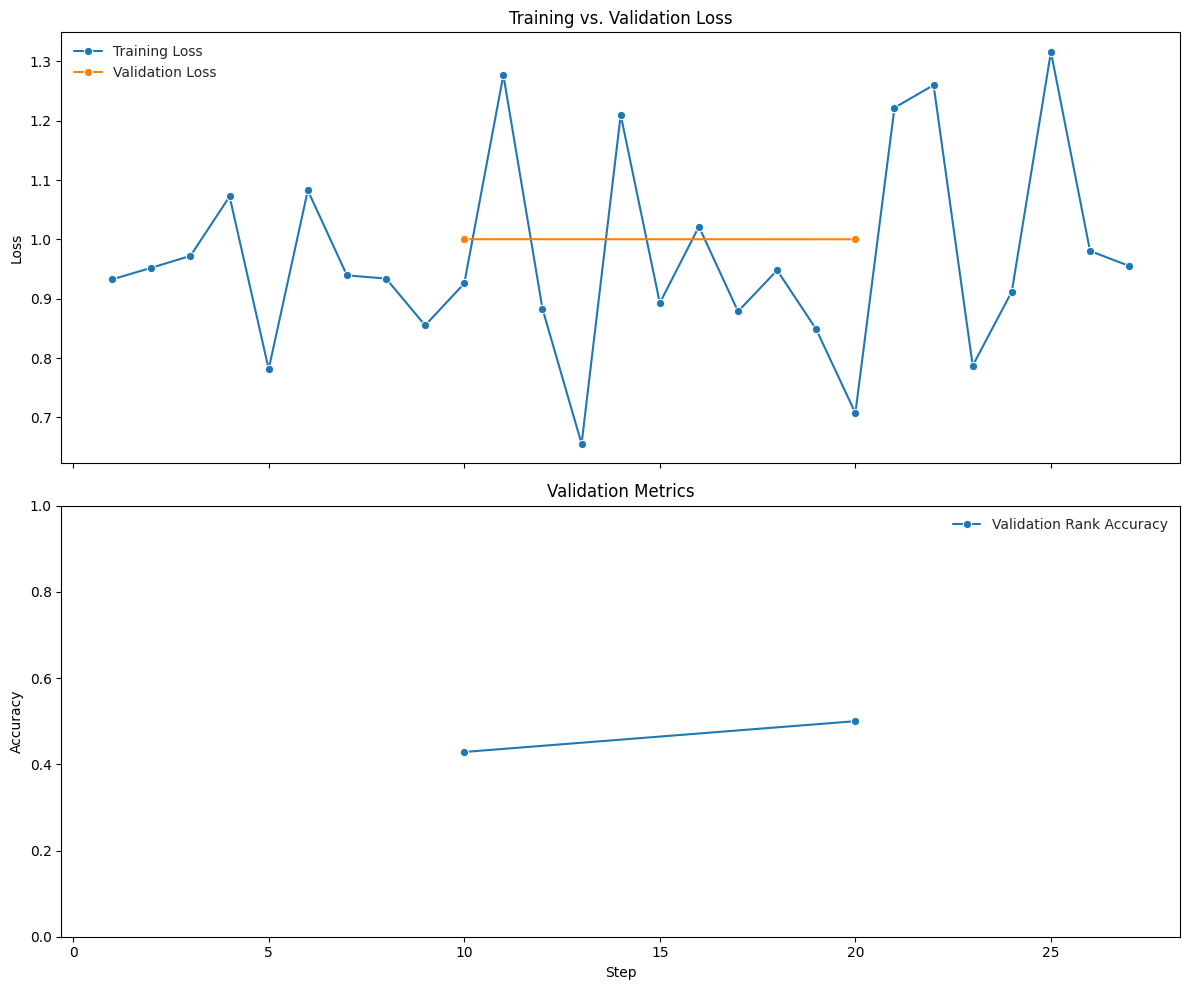


--- Best Model Evaluation Metrics (from validation set) ---
Best Step (based on min eval_loss): 20.0
Best Validation Loss: 1.0002
Best Validation Rank Accuracy: 0.5000


In [9]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_rank_accuracy', label='Validation Rank Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Step')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Step (based on min eval_loss): {best_run['step']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation Rank Accuracy: {best_run['eval_rank_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")